## Predict how much energy will a building consume with Fedot.Industrial

Dataset published on Kaggle, aims to assess the value of energy efficiency improvements. For that purpose, four types of sources are identified: electricity, chilled water, steam and hot water. The goal is to estimate the **energy consumption in kWh**. Dimensions correspond to the air temperature, dew temperature, wind direction and wind speed. These values were taken hourly during a week, and the output is the meter reading of the four aforementioned sources. In this way, was created four datasets:  **ChilledWaterPredictor**, **ElectricityPredictor**, **HotwaterPredictor**, and **SteamPredictor**.
Link to the dataset - https://www.kaggle.com/code/fatmanuranl/ashrae-energy-prediction2

In [2]:
import pandas as pd
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.api.main import FedotIndustrial

In [3]:
def evaluate_loop(api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

In [4]:
initial_assumption = PipelineBuilder().add_node('quantile_extractor').add_node('treg')
params = dict(problem='regression',
                             metric='rmse',
                             timeout=30,
                             initial_assumption=initial_assumption,
                             n_jobs=2,
                             logging_level=20)
dataset_name = 'HotwaterPredictor'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [5]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-04-05 12:27:32,955 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/HotwaterPredictor


In [6]:
import numpy as np
features = np.array(train_data[0].values.tolist()).astype(float)

Lets check our data.

In [7]:
features.shape

(245, 4, 168)

Lets visualise our predictors.

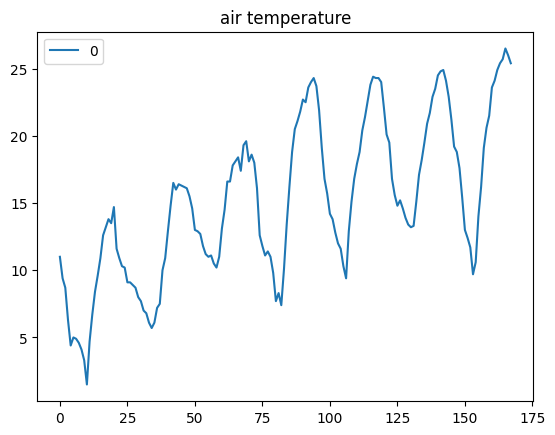

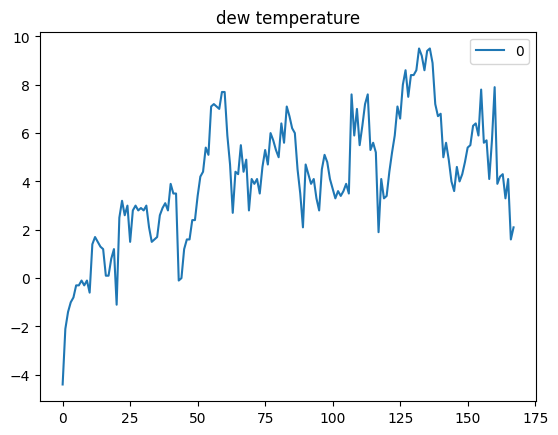

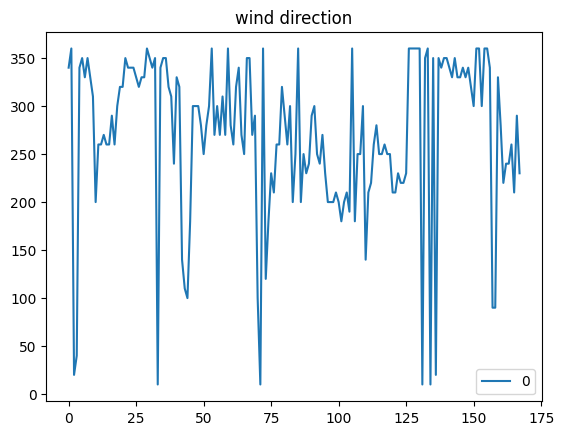

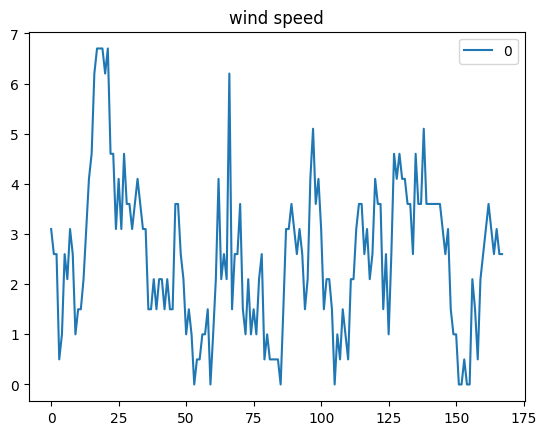

In [17]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='air temperature')
pd.DataFrame(features[1, 1, :]).plot(title='dew temperature')
pd.DataFrame(features[1, 2, :]).plot(title='wind direction')
pd.DataFrame(features[1, 3, :]).plot(title='wind speed')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [9]:
industrial_model =  evaluate_loop(api_params=params, finetune=True)

2024-04-05 12:28:47,939 - Initialising experiment setup
2024-04-05 12:28:47,945 - Initialising Industrial Repository
2024-04-05 12:28:49,424 - Initialising Dask Server
Creating Dask Server
2024-04-05 12:28:51,241 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-05 12:28:51,306 - State start
2024-04-05 12:28:52,549 -   Scheduler at: inproc://10.64.4.217/16120/1
2024-04-05 12:28:52,550 -   dashboard at:  http://10.64.4.217:59060/status
2024-04-05 12:28:52,551 - Registering Worker plugin shuffle
2024-04-05 12:28:53,818 -       Start worker at: inproc://10.64.4.217/16120/4
2024-04-05 12:28:53,819 -          Listening to:          inproc10.64.4.217
2024-04-05 12:28:53,819 -           Worker name:                          0
2024-04-05 12:28:53,821 -          dashboard at:          10.64.4.217:59062
2024-04-05 12:28:53,821 - Waiting to connect to: inproc://10.64.4.217/16120/1
2024-04-05 12:28:53,822 - --------

[I 2024-04-05 12:39:15,194] A new study created in memory with name: no-name-29f752e9-6f19-4999-a100-37fb5b4ae81f


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-05 12:39:28,744] Trial 1 finished with value: 1243.4050524949241 and parameters: {'0 || treg | max_features': 0.5713754630439515, '0 || treg | min_samples_split': 18, '0 || treg | min_samples_leaf': 1, '0 || treg | bootstrap': False}. Best is trial 1 with value: 1243.4050524949241.
[I 2024-04-05 12:39:28,961] Trial 4 finished with value: 1427.1990035718338 and parameters: {'0 || treg | max_features': 0.9891193733364071, '0 || treg | min_samples_split': 5, '0 || treg | min_samples_leaf': 8, '0 || treg | bootstrap': True}. Best is trial 1 with value: 1243.4050524949241.
[I 2024-04-05 12:39:29,009] Trial 5 finished with value: 1491.1469390520735 and parameters: {'0 || treg | max_features': 0.14840544757122093, '0 || treg | min_samples_split': 17, '0 || treg | min_samples_leaf': 19, '0 || treg | bootstrap': False}. Best is trial 1 with value: 1243.4050524949241.
[I 2024-04-05 12:39:29,367] Trial 7 finished with value: 1491.1469390520735 and parameters: {'0 || treg | max_features

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [10]:
labels = industrial_model.predict(test_data)
metrics = industrial_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [11]:
metrics

,r2,rmse,mae
0,0.202,1178.575,717.016


## AutoML approach

In [12]:
industrial_auto_model = evaluate_loop(api_params=params, finetune=False)

2024-04-05 12:44:50,707 - Initialising experiment setup
2024-04-05 12:44:50,713 - Initialising Industrial Repository
2024-04-05 12:44:50,714 - Initialising Dask Server
Creating Dask Server
2024-04-05 12:44:50,735 - State start
2024-04-05 12:44:51,981 -   Scheduler at: inproc://10.64.4.217/16120/9
2024-04-05 12:44:51,981 -   dashboard at:  http://10.64.4.217:59465/status
2024-04-05 12:44:51,982 - Registering Worker plugin shuffle
2024-04-05 12:44:53,252 -       Start worker at: inproc://10.64.4.217/16120/12
2024-04-05 12:44:53,253 -          Listening to:          inproc10.64.4.217
2024-04-05 12:44:53,254 -           Worker name:                          0
2024-04-05 12:44:53,255 -          dashboard at:          10.64.4.217:59468
2024-04-05 12:44:53,255 - Waiting to connect to: inproc://10.64.4.217/16120/9
2024-04-05 12:44:53,256 - -------------------------------------------------
2024-04-05 12:44:53,256 -               Threads:                          8
2024-04-05 12:44:53,256 -     

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-05 12:44:56,271 - IndustrialDispatcher - Number of used CPU's: 2


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289F9FFF550>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2791627608592
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289F9F3E9D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2791634387280


2024-04-05 12:45:26,996 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-05 12:45:27,040 - IndustrialEvoOptimizer - Generation num: 1 size: 1
2024-04-05 12:45:27,042 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=1261.166 node_number=0.200>']
2024-04-05 12:45:28,011 - IndustrialDispatcher - Number of used CPU's: 2


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289FA351940>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2791631898928
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289FA125430>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2791671405712
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289FA6145E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2791671403792
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-04-05 13:03:50,131 - IndustrialDispatcher - 14 individuals out of 21 in previous population were evaluated successfully.
2024-04-05 13:03:50,187 - IndustrialEvoOptimizer - Generation num: 2 size: 14
2024-04-05 13:03:50,190 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=1261.166 node_number=0.200>']
2024-04-05 13:03:50,192 - IndustrialEvoOptimizer - no improvements for 1 iterations
2024-04-05 13:03:50,194 - IndustrialEvoOptimizer - spent time: 18.9 min
2024-04-05 13:03:50,195 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [18:53<?, ?gen/s]

2024-04-05 13:03:50,199 - OptimisationTimer - Composition time: 18.899 min
2024-04-05 13:03:50,200 - OptimisationTimer - Algorithm was terminated due to processing time limit
2024-04-05 13:03:50,205 - IndustrialEvoOptimizer - Generation num: 3 size: 1
2024-04-05 13:03:50,206 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=1261.166 node_number=0.200>']
2024-04-05 13:03:50,207 - IndustrialEvoOptimizer - no improvements for 2 iterations
2024-04-05 13:03:50,208 - IndustrialEvoOptimizer - spent time: 18.9 min
2024-04-05 13:03:50,211 - GPComposer - GP composition finished
2024-04-05 13:03:50,214 - DataSourceSplitter - Stratificated splitting of data is disabled.
2024-04-05 13:03:50,217 - DataSourceSplitter - Hold out validation is applied.
2024-04-05 13:03:50,224 - ApiComposer - Hyperparameters tuning started with 11 min. timeout
2024-04-05 13:03:50,227 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


2024-04-05 13:03:58,366 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {} 
Initial metric: [1214.155]
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2024-04-05 13:03:58,400 - build_posterior_wrapper took 0.012965 seconds
2024-04-05 13:03:58,403 - TPE using 0 trials
  0%|          | 1/100000 [00:05<147:08:05,  5.30s/trial, best loss: 1342.1776327892146]2024-04-05 13:04:03,700 - build_posterior_wrapper took 0.011004 seconds
2024-04-05 13:04:03,702 - TPE using 1/1 trials with best loss 1342.177633
  0%|          | 2/100000 [00:13<187:54:23,  6.76s/trial, best loss: 1341.463928616054] 2024-04-05 13:04:11,491 - build_posterior_wrapper took 0.012969 seconds
2024-04-05 13:04:11,493 - TPE using 2/2 trials with best loss 1341.463929
  0%|          | 3/100000 [00:19<185:38:40,  6.68s/trial, best loss: 1296.536593611193]2024-04-05 13:04:18,077 - build_posterior_wrapper took 0.011962 seconds
2024-04-05 1

In [13]:
auto_labels = industrial_auto_model.predict(test_data)
auto_metrics = industrial_auto_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [14]:
auto_metrics

,r2,rmse,mae
0,0.216,1168.245,710.851


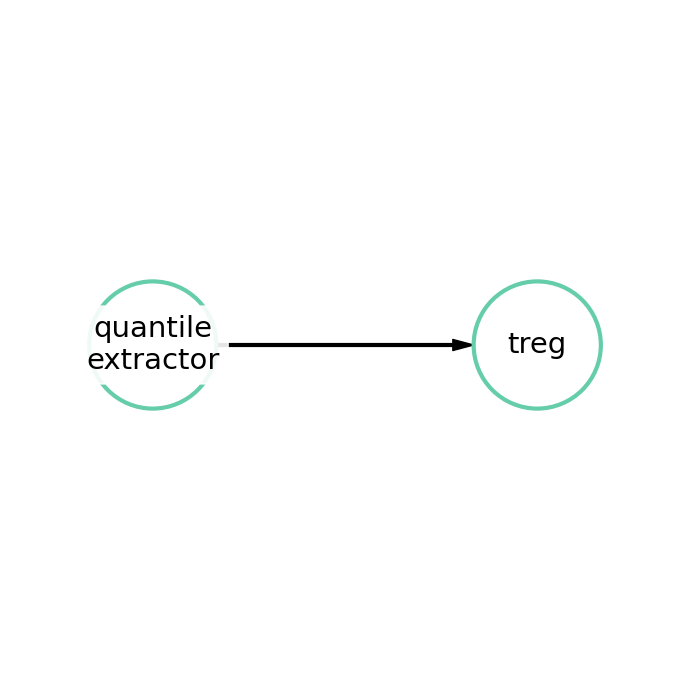

2024-04-05 13:14:59,231 - OperationsAnimatedBar - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 13:14:59,367 - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-04-05 13:14:59,367 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-04-05 13:15:05,640 - OperationsAnimatedBar - The animation was saved to "D:\WORK\Repo\Industiral\IndustrialTS\results_of_experiments\history_animated_bars.gif".
2024-04-05 13:15:05,642 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 13:15:05,665 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-05 13:15:05,670 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the a

In [15]:
industrial_auto_model.solver.current_pipeline.show()
industrial_auto_model.plot_operation_distribution(mode='each')
industrial_auto_model.plot_fitness_by_generation()

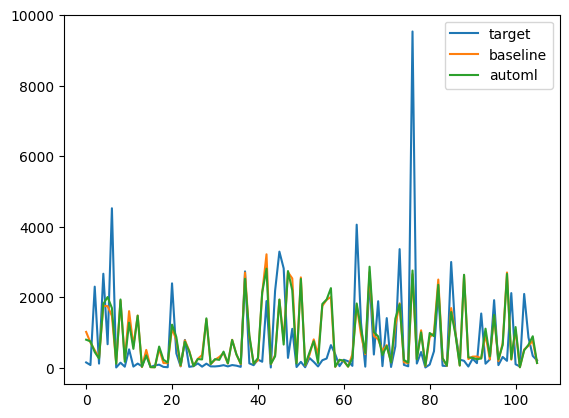

In [18]:
predictions = np.vstack([test_data[1].flatten(),labels.flatten(),auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target','baseline','automl'])
all_prediction.plot()
plt.show()

2024-04-05 13:19:45,408 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 13:19:45,432 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-05 13:19:45,440 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


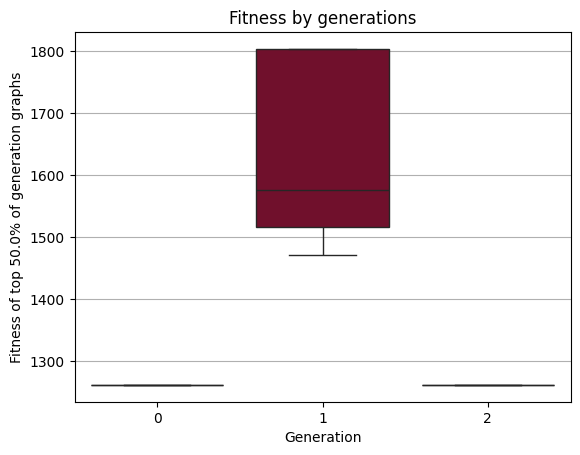

In [24]:
industrial_auto_model.solver.history.show.fitness_box(best_fraction=0.5, dpi=100)

In [25]:
industrial_auto_model.solver.return_report()

,days,hours,minutes,seconds,milliseconds
Data Definition (fit),0,0,0,0,2
Data Preprocessing,0,0,0,0,184
Fitting (summary),0,0,30,4,637
Composing,0,0,18,56,906
Train Inference,0,0,0,2,331
Tuning (composing),0,0,11,5,178
Tuning (after),0,0,0,0,0
Data Definition (predict),0,0,0,0,0
Predicting,0,0,0,0,759


2024-04-05 13:19:50,131 - OperationsKDE - Visualizing optimization history... It may take some time, depending on the history size.


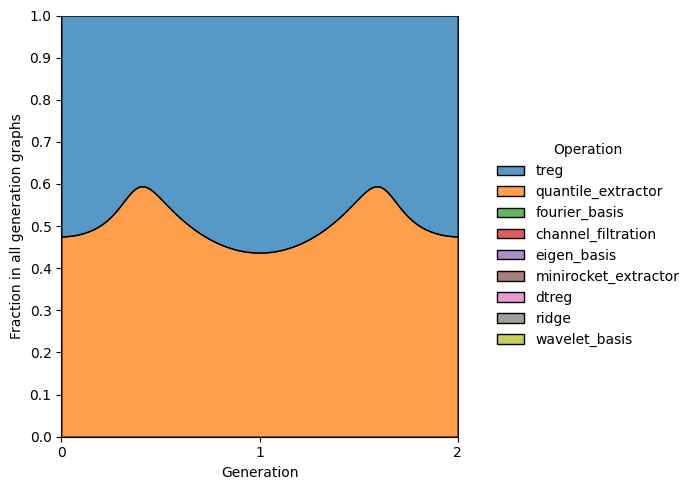

In [26]:
industrial_auto_model.solver.history.show.operations_kde(dpi=100)

## Compare with State of Art (SOTA) models

In [19]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [20]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [21]:
df.sort_values('min')['min']

CNN_RMSE                    867.167248
FCN_RMSE                    886.301979
InceptionT_RMSE             958.396510
SingleInception_RMSE        961.233445
ResNet_RMSE                 973.711924
RDST_RMSE                   986.749722
RIST_RMSE                  1032.905074
FPCR_RMSE                  1047.799053
ROCKET_RMSE                1049.727695
FreshPRINCE_RMSE           1051.735216
MultiROCKET_RMSE           1065.140487
5NN-DTW_RMSE               1071.163827
RandF_RMSE                 1076.629639
DrCIF_RMSE                 1080.966688
FPCR-Bs_RMSE               1099.364430
5NN-ED_RMSE                1110.793732
XGBoost_RMSE               1155.910532
Fedot_Industrial_AutoML    1168.245000
TSF_RMSE                   1178.412908
Fedot_Industrial_tuned     1178.575000
RotF_RMSE                  1189.173860
Grid-SVR_RMSE              1246.184958
1NN-DTW_RMSE               1396.816565
1NN-ED_RMSE                1615.919446
Ridge_RMSE                 2286.355459
Name: min, dtype: float64

In [22]:
df.sort_values('max')['max']

Fedot_Industrial_AutoML    1168.245000
Fedot_Industrial_tuned     1178.575000
RDST_RMSE                  1223.537234
FCN_RMSE                   1261.023121
RIST_RMSE                  1286.172802
ResNet_RMSE                1314.236132
CNN_RMSE                   1329.048575
ROCKET_RMSE                1381.935767
SingleInception_RMSE       1403.745725
DrCIF_RMSE                 1426.485773
InceptionT_RMSE            1432.379154
FreshPRINCE_RMSE           1467.946007
MultiROCKET_RMSE           1479.726986
RandF_RMSE                 1529.707449
FPCR_RMSE                  1566.918068
RotF_RMSE                  1597.388873
XGBoost_RMSE               1620.479639
TSF_RMSE                   1624.255525
5NN-DTW_RMSE               1652.839501
FPCR-Bs_RMSE               1667.648841
5NN-ED_RMSE                1825.271162
Grid-SVR_RMSE              1934.918113
1NN-DTW_RMSE               2101.344987
1NN-ED_RMSE                2322.456606
Ridge_RMSE                 3337.671272
Name: max, dtype: float64

In [23]:
df.sort_values('average')['average']

FCN_RMSE                   1072.502657
RDST_RMSE                  1142.764246
ResNet_RMSE                1145.645542
InceptionT_RMSE            1156.251420
SingleInception_RMSE       1162.325568
Fedot_Industrial_AutoML    1168.245000
RIST_RMSE                  1172.270167
CNN_RMSE                   1174.255738
Fedot_Industrial_tuned     1178.575000
ROCKET_RMSE                1236.408458
FreshPRINCE_RMSE           1240.376659
DrCIF_RMSE                 1246.467591
MultiROCKET_RMSE           1252.545137
RandF_RMSE                 1310.439205
FPCR_RMSE                  1331.504687
5NN-DTW_RMSE               1337.373398
RotF_RMSE                  1383.306131
TSF_RMSE                   1401.285094
XGBoost_RMSE               1424.823440
FPCR-Bs_RMSE               1427.171255
5NN-ED_RMSE                1458.866739
Grid-SVR_RMSE              1587.147748
1NN-DTW_RMSE               1819.103151
1NN-ED_RMSE                1906.032299
Ridge_RMSE                 2719.383329
Name: average, dtype: flo